In [147]:
# Author: Mikita Sazanovich

%matplotlib inline
from time import time
import matplotlib.pyplot as plt

import numpy as np

eps_greedy = 0.2
gamma = 0.9
field_size = 10
cows = [(field_size - 1, field_size - 1)]
pickup_reward = 100

max_iterations = 500

In [52]:
class Action:
    def __init__(self, to_state, reward):
        self.to_state = to_state
        self.reward = reward


class State:
    def __init__(self, x, y, cow_mask):
        self.x = x
        self.y = y
        self.cow_mask = cow_mask
        self.actions = []

    def is_terminal(self):
        return self.x == 0 and self.y == 0 and self.cow_mask != 0

    def add_action(self, action):
        self.actions.append(action)

    def __eq__(self, other):
        if isinstance(other, State):
            return (self.x == other.x
                    and self.y == other.y
                    and self.cow_mask == other.cow_mask)
        else:
            return False

    def __hash__(self):
        return hash((self.x, self.y, self.cow_mask))

    def __str__(self):
        return str(self.x) + " " + str(self.y) + " " + str(self.cow_mask)

In [148]:
def build_states(N, cows, pickup_reward):
    def is_valid_cell(x, y):
        return 0 <= x < N and 0 <= y < N

    dirs = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    S = []
    max_mask = 1 << len(cows)
    for x in range(N):
        for y in range(N):
            for mask in range(max_mask):
                S.append(State(x, y, mask))
    for s in S:
        if s.is_terminal():
            s.add_action(Action(s, 0))
            continue
        x, y, mask = s.x, s.y, s.cow_mask
        for drt in dirs:
            xx = x + drt[0]
            yy = y + drt[1]
            if is_valid_cell(xx, yy):
                new_mask = mask
                if (xx, yy) in cows:
                    cow_index = cows.index((xx, yy))
                    new_mask |= 1 << cow_index
                to_state = S[S.index(State(xx, yy, new_mask))]
                if to_state.is_terminal():
                    reward = pickup_reward * bin(new_mask).count('1')
                else:
                    reward = 0
                s.add_action(Action(to_state, reward))
    return S


S = build_states(field_size, cows, pickup_reward)


In [138]:
def measure_policy_performance(S, pi, max_iters=1000):
    state = S[S.index(State(0, 0, 0))]
    for _ in range(max_iters):
        if pi[state] is None:
            break
        action = pi[state]
        state = action.to_state
        if state.is_terminal():
            return action.reward
    return 0.0


def plot_method_results(S, method):
    seed_n = 10
    seeds = range(seed_n)
    learning_started = time()
    perf_mean = None
    for seed in seeds:
        np.random.seed(seed)
        perf = method(S, max_iterations=max_iterations)
        if perf_mean is None:
            perf_mean = np.zeros(len(perf), dtype=float)
        perf_mean += perf
    perf_mean /= seed_n
    print(f'measuring with {seed_n} seeds took', time() - learning_started)
    line, = plt.plot(perf_mean, label=method, c='C8')
    plt.legend(handles=[line])
    plt.show()


measuring with 10 seeds took 0.40105700492858887


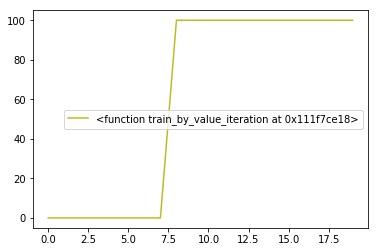

In [118]:
def train_by_value_iteration(S, max_iterations, delta_eps=1e-6):
    V, pi = {}, {}
    for state in S:
        V[state] = 0.0
        pi[state] = None

    def find_best_action(state):
        best_action, best_v = None, None
        for action in state.actions:
            to_state = action.to_state
            cur_v = action.reward + gamma * V[to_state]
            if best_v is None or cur_v > best_v:
                best_action, best_v = action, cur_v
        return best_action, best_v

    perf = []
    for _ in range(max_iterations):
        delta = 0.0
        for state in S:
            if state.is_terminal():
                continue
            old_v = V[state]
            _, best_v = find_best_action(state)
            V[state] = best_v
            delta = max(delta, abs(best_v - old_v))
        for state in S:
            best_action, _ = find_best_action(state)
            pi[state] = best_action
        perf.append(measure_policy_performance(S, pi))
        if delta < delta_eps:
            break
    return perf

plot_method_results(S, train_by_value_iteration)

Util methods for working with stochastic policies

In [15]:
def choose_action_from_stochastic_policy(pi, state):
    p = []
    for aindex in range(len(state.actions)):
        p.append(pi[(state, aindex)])
    return np.random.choice(len(state.actions), 1, p=p)[0]


def find_best_action_quality(Q, state):
    best_aindex, best_q = None, None
    for aindex in range(len(state.actions)):
        cur_q = Q[(state, aindex)]
        if best_q is None or best_q < cur_q:
            best_aindex, best_q = aindex, cur_q
    return best_aindex, best_q


def update_pi_eps_greedy(pi, Q, state):
    best_aindex, best_q = find_best_action_quality(Q, state)
    best_count = 0
    for aindex in range(len(state.actions)):
        if Q[(state, aindex)] == best_q:
            best_count += 1
    for aindex in range(len(state.actions)):
        if Q[(state, aindex)] == best_q:
            pi[(state, aindex)] = ((1 - eps_greedy) / best_count +
                                   eps_greedy / len(state.actions))
        else:
            pi[(state, aindex)] = eps_greedy / len(state.actions)


def determine_policy(S, Q):
    pi = {}
    for state in S:
        best_aindex, _ = find_best_action_quality(Q, state)
        if best_aindex is None:
            pi[state] = None
        else:
            pi[state] = state.actions[best_aindex]
    return pi

measuring with 10 seeds took 26.173680067062378


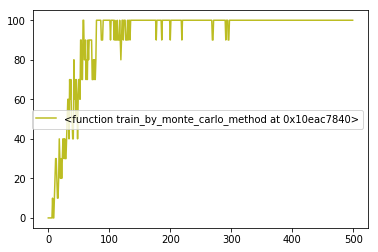

In [149]:
def train_by_monte_carlo_method(S, max_iterations):
    Q, cumulative, total, pi = {}, {}, {}, {}
    for state in S:
        for aindex in range(len(state.actions)):
            Q[(state, aindex)] = 0.0
            cumulative[(state, aindex)] = 0
            total[(state, aindex)] = 0
            pi[(state, aindex)] = 1.0 / len(state.actions)

    def run_single_episode():
        episode_log = []
        state = S[S.index(State(0, 0, 0))]
        while True:
            choice_index = choose_action_from_stochastic_policy(pi, state)
            episode_log.append((state, choice_index))
            action = state.actions[choice_index]
            state = action.to_state
            if state.is_terminal():
                return episode_log, action.reward

    perf = []
    for _ in range(max_iterations):
        episode_log, reward = run_single_episode()
        seen_pairs = set()
        seen_states = set()
        for ind, pair in enumerate(episode_log):
            if pair in seen_pairs:
                continue
            seen_pairs.add(pair)
            cumulative[pair] += reward * np.power(gamma,
                                                 len(episode_log) - ind - 1)
            total[pair] += 1
            Q[pair] = cumulative[pair] / total[pair]
            seen_states.add(pair[0])
        for state in seen_states:
            update_pi_eps_greedy(pi, Q, state)
        perf.append(measure_policy_performance(S, determine_policy(S, Q)))
    return perf


plot_method_results(S, train_by_monte_carlo_method)

measuring with 10 seeds took 31.567353010177612


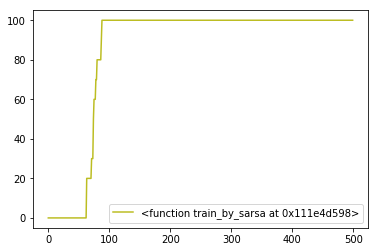

In [120]:
def train_by_sarsa(S, max_iterations, alpha=0.1):
    Q, pi = {}, {}
    for state in S:
        for aindex in range(len(state.actions)):
            Q[(state, aindex)] = 0.0
            pi[(state, aindex)] = 1.0 / len(state.actions)
    perf = []
    for _ in range(max_iterations):
        state = S[S.index(State(0, 0, 0))]
        aindex = choose_action_from_stochastic_policy(pi, state)
        while not state.is_terminal():
            action = state.actions[aindex]
            to_state = action.to_state
            to_aindex = choose_action_from_stochastic_policy(pi, to_state)
            Q[(state, aindex)] += alpha * (action.reward +
                                           gamma * Q[(to_state, to_aindex)] -
                                           Q[(state, aindex)])
            update_pi_eps_greedy(pi, Q, state)
            state, aindex = to_state, to_aindex
        perf.append(measure_policy_performance(S, determine_policy(S, Q)))
    return perf


plot_method_results(S, train_by_sarsa)

measuring with 10 seeds took 32.66626286506653


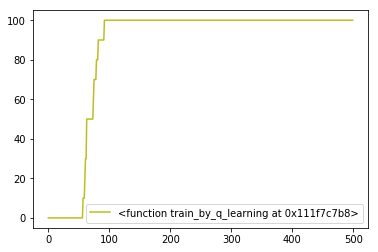

In [124]:
def train_by_q_learning(S, max_iterations, alpha=0.1):
    Q, pi = {}, {}
    for state in S:
        for aindex in range(len(state.actions)):
            Q[(state, aindex)] = 0.0
            pi[(state, aindex)] = 1.0 / len(state.actions)
    perf = []
    for _ in range(max_iterations):
        state = S[S.index(State(0, 0, 0))]
        while not state.is_terminal():
            aindex = choose_action_from_stochastic_policy(pi, state)
            action = state.actions[aindex]
            to_state = action.to_state
            _, best_to_q = find_best_action_quality(Q, to_state)
            Q[(state, aindex)] += alpha * (action.reward +
                                           gamma * best_to_q -
                                           Q[(state, aindex)])
            update_pi_eps_greedy(pi, Q, state)
            state = to_state
        perf.append(measure_policy_performance(S, determine_policy(S, Q)))
    return perf


plot_method_results(S, train_by_q_learning)

Now let's try to increase the number of cows around the field and reevaluate the methods.

In [125]:
cows = [(field_size-5, field_size-5), 
        (field_size-5, field_size-1), 
        (field_size-1, field_size-5)]
S = build_states(field_size, cows, pickup_reward)

measuring with 10 seeds took 0.7505807876586914


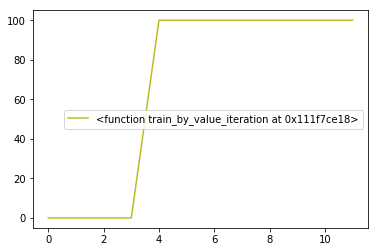

In [137]:
plot_method_results(S, train_by_value_iteration)

measuring with 10 seeds took 55.24452495574951


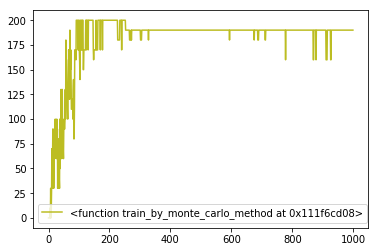

In [139]:
plot_method_results(S, train_by_monte_carlo_method)

measuring with 10 seeds took 53.62889814376831


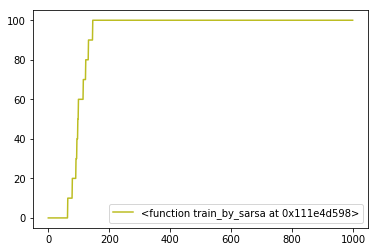

In [140]:
plot_method_results(S, train_by_sarsa)

measuring with 10 seeds took 52.82578778266907


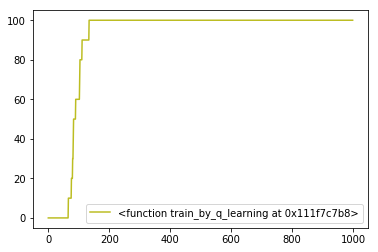

In [141]:
plot_method_results(S, train_by_q_learning)

We can clearly see the trend: 
- value iteration has no exploration and that's why we end up exploting one reward;
- Q and SARSA learning use an update rule with the immediate reward and that's why it is hard to propogate more than one deferred reward;
- Monte Carlo method performs best: since it utilizes exploration and updates the Q function based on the final reward.